In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
# Atype = CuArray{Float32}

KnetArray{Float32, N} where N

In [2]:
const F = Float32
params = Knet.params

params (generic function with 2 methods)

In [3]:
logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

In [4]:
include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [5]:
dataset_name = "mnist"
notebook_name = "VAE_Baseline" * "_" * dataset_name

if !isdir("Results")
   mkdir("Results") 
end
if  !isdir(joinpath("Results", notebook_name))
    mkdir(joinpath("Results", notebook_name))
end

if  !isdir(joinpath("Results", notebook_name, "Saved_Models"))
    mkdir(joinpath("Results", notebook_name, "Saved_Models"))
end

if  !isdir(joinpath("Results", notebook_name, "Images"))
    mkdir(joinpath("Results", notebook_name, "Images"))
end

if  !isdir(joinpath("Results", notebook_name, "Logger"))
    mkdir(joinpath("Results", notebook_name, "Logger"))
end

In [6]:
push!(logger, DefaultHandler(joinpath("Results", notebook_name, "Logger", "logger.log"),DefaultFormatter("[{date} | {level} | {name}]: {msg}")));

In [7]:
use_saved_data = false

if dataset_name == "mnist"
    
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = atype);

,,,,,,,,,

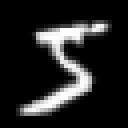
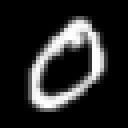
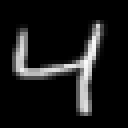
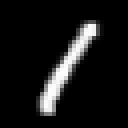
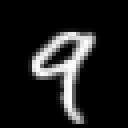
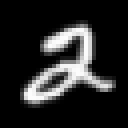
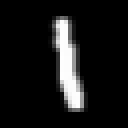
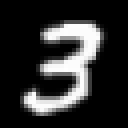
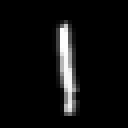
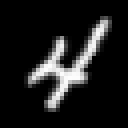

In [8]:
k = 1:10
if use_saved_data
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,:,j], (32, 32))) for j in k]
else
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]
end

In [9]:
function weights(nc, nz, ngf) 
    
    # Encoding Weights
    phi = [] # x -> z
    
    w,b = conv_weight_init(4, 4, nc, ngf; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    push!(phi, bnparams(ngf))
    
    w,b = conv_weight_init(4, 4, ngf, ngf * 2; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    push!(phi, bnparams(ngf * 2))
    
    w,b = conv_weight_init(4, 4, ngf * 2, ngf * 4; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    push!(phi, bnparams(ngf * 4))
    
    w,b = conv_weight_init(4, 4, ngf * 4, nz; bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    
    w, b = linlayer_weight_init(nz, nz;bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    
    w, b = linlayer_weight_init(nz, nz;bias = true, return_param = false)
    push!(phi, w)
    push!(phi, b)
    
    # Decoding Weights
    theta = [] # z -> x
    
    w, b = deconv_weight_init(4, 4, nz, ngf * 4;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 4))) # Batch Normalization
    
    w, b = deconv_weight_init(4, 4, ngf * 4, ngf * 2;bias= true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 2)))
    
    w, b = deconv_weight_init(4, 4, ngf * 2, ngf;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf)))
    
    w,b = deconv_weight_init(4,4,ngf, 1;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    
    phi = map(a->convert(atype,a), phi)
    theta = map(a->convert(atype,a), theta)
#     theta = map(a->convert(Param,a), theta)
    
    return Param.(theta), Param.(phi)
end

weights (generic function with 1 method)

In [10]:
function reparametrize(mu, logvar)
    
    std = exp.(0.5 .* logvar)
    epsilon = convert(atype, randn(F, size(mu)))
    z = mu .+ epsilon .* std
    
    return z
end

moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()
moments4 = bnmoments()
moments5 = bnmoments()
moments6 = bnmoments()

# DEFINE ENCODING FUNCTION (MODEL)
function encode(phi, x; batch_size = 64, training = true)
    
    z =  conv4(phi[1], x, mode = 1, stride = 2, padding = 1) .+ phi[2]
    z = mybatchnorm(z, moments1, phi[3]; training = training)
    z = Knet.elu.(z)
    
    z = conv4(phi[4], z, mode = 1, stride = 2, padding = 1) .+ phi[5]
    z = mybatchnorm(z, moments2, phi[6]; training = training)
    z = Knet.elu.(z)
    
    z =  conv4(phi[7], z, mode = 1, stride = 2, padding = 1) .+ phi[8]
    z = mybatchnorm(z, moments3, phi[9]; training = training)
    z = Knet.elu.(z)
    
    z = conv4(phi[10], z, mode = 1) .+ phi[11]
    z = Knet.elu.(z)
    
    #z = reshape(z, (size(z,3), size(z,4)))
    z = reshape(z, (nz, batch_size))
    mu = phi[12] * z .+ phi[13]
    logvar = phi[14] * z .+ phi[15]
    
    z = reparametrize(mu, logvar)
    
    return z, mu, logvar
end

function decode(theta, z; batch_size = 64, training = true)
        
    z = reshape(z, (1, 1, nz, batch_size))
    z = deconv4(theta[1], z, mode = 1) .+ theta[2]
    z = mybatchnorm(z, moments4, theta[3]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[4], z, stride = 2, padding = 1, mode = 1) .+ theta[5]
    z = mybatchnorm(z, moments5, theta[6]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[7], z, stride = 2, padding = 1, mode = 1) .+ theta[8]
    z = mybatchnorm(z, moments6, theta[9]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[10], z, stride = 2, padding = 1, mode = 1) .+ theta[11]
    x_hat = Knet.sigm.(z)

    return x_hat

end

function VAEsample(theta, nz, batch_size; training = true)

    z = atype(randn(1,1, nz, batch_size))
    
    x_hat = decode(theta, z; batch_size = batch_size, training = training)

    return x_hat
end

function encode_decode(theta, phi, x; training = true)
    batch_size = size(x,4)
    z, mu, logvar = encode(phi, x; batch_size = batch_size, training = training)
    x_hat = decode(theta, z; batch_size = batch_size, training = training)
    return x_hat, mu, logvar
end

encode_decode (generic function with 1 method)

In [11]:
function loss(theta, phi, x)
    
#     batch_size = size(x,4) 
    z, mu, logvar = encode(phi, x)
    x_hat = decode(theta, z)
    L = BCE(x, x_hat) + KLD(mu, logvar)
    return L
    
end

function loss(theta, phi, d::Data)
    
    total_loss = 0
    n_instance = 0
    for x in d
        total_loss += loss(theta, phi, x) * size(x,4)
        n_instance += size(x,4)
    end

    total_loss /= n_instance
end

## Sum Squared Error Definition
rec_loss(m, theta, phi, x) = sum((x - m(theta, phi, x)[1]).^2) / size(x,4)

function rec_loss(m, theta, phi, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += rec_loss(m, theta, phi, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

rec_loss (generic function with 2 methods)

In [12]:
nz = 256
ngf = 16
nc = 1

x = first(dtrn)

theta, phi = weights(nc, nz,  ngf);

In [13]:
loss(theta, phi, x)

842.9994993209839

In [14]:
loss(theta, phi, dtrn)

846.2343272552165

In [15]:
@diff loss(theta, phi, x)

T(846.5265989303589)

In [24]:
@diff rec_loss(encode_decode, theta, phi, x)

T(315.73874)

In [26]:
@diff loss(theta, phi, x)

T(973.0028705596924)

In [16]:
nz = 48
ngf = 16
# nc = 1

# first batch of the test dataset
x_test_first = first(dtst);

# Initialize random model weights
theta, phi = weights(nc, nz, ngf);

# Define Learning Rate and Number of Epochs
lr = 2*1e-4
n_epochs = 5 # MAKE THIS 1000

# Specify the optimizer for each param
for p in params(theta)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end

for p in params(phi)
    p.opt =  Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999)
end

# Initialize Empty Lists for both training and test losses
trn_loss_list = Float64[]
tst_loss_list = Float64[]
trn_rec_loss_list = Float64[]
tst_rec_loss_list = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss(theta, phi, dtrn)
epoch_loss_tst_ = loss(theta, phi, dtst)
epoch_rec_loss_trn_ = rec_loss(encode_decode, theta, phi, dtrn)
epoch_rec_loss_tst_ = rec_loss(encode_decode, theta, phi, dtst)

push!(trn_loss_list, epoch_loss_trn_)
push!(tst_loss_list, epoch_loss_tst_)
push!(trn_rec_loss_list, epoch_rec_loss_trn_)
push!(tst_rec_loss_list, epoch_rec_loss_tst_)

# println("Epoch : ", 0)
# println("Train Loss : ",epoch_loss_trn_)
# println("Test Loss : ", epoch_loss_tst_)
# println("Train Reconstruction Loss : ", epoch_rec_loss_trn_)
# println("Test Reconstruction Loss : ", epoch_rec_loss_tst_)

info(logger, ("Epoch : 0"))
info(logger, ("Train Loss : $epoch_loss_trn_"))
info(logger, ("Test Loss : $epoch_loss_tst_"))
info(logger, ("Train Reconstruction Loss : $epoch_rec_loss_trn_"))
info(logger, ("Test Reconstruction Loss : $epoch_rec_loss_tst_ \n"))

# Define the step number of model save checkpoint
model_save_checkpoint = 1 # I RECOMMEND DOING THIS 100
logger_checkpoint = 1
image_rec_checkpoint = 50

# Training Loop
for epoch in progress(1:n_epochs)
    
    # # DECREASE LEARNING RATE AFTER 50 EPOCHS
    # if epoch > 50
    #    lr = 1e-4 
    # end
    
    for (i,x) in enumerate(dtrn)
        
        # CALCULATE THE GRADIENT OF THE LOSS FUNCTION W.R.T. MODEL WEIGHTS
        derivative_model = @diff loss(theta, phi, x)
        
        # UPDATE MODEL WEIGHTS WITH ADAM OPTIMIZER
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end
        
        for p in phi
            dp = grad(derivative_model, p)
            update!(value(p), dp, p.opt)
        end
        
    end
    
    # Record Training and Test Losses
    epoch_loss_trn = loss(theta, phi, dtrn)
    epoch_loss_tst = loss(theta, phi, dtst)
    epoch_rec_loss_trn = rec_loss(encode_decode, theta, phi, dtrn)
    epoch_rec_loss_tst = rec_loss(encode_decode, theta, phi, dtst)
    
    push!(trn_loss_list, epoch_loss_trn)
    push!(tst_loss_list, epoch_loss_tst)
    push!(trn_rec_loss_list, epoch_rec_loss_trn)
    push!(tst_rec_loss_list, epoch_rec_loss_tst)
    
#     println("Epoch : ", epoch)
#     println("Train Loss : ",epoch_loss_trn)
#     println("Test Loss : ", epoch_loss_tst)
#     println("Train Reconstruction Loss : ", epoch_rec_loss_trn)
#     println("Test Reconstruction Loss : ", epoch_rec_loss_tst)
    
    # Print losses to the logger file
    if epoch % logger_checkpoint == 0
        info(logger,"Epoch : $epoch")
        info(logger,"Train Loss : $epoch_loss_trn")
        info(logger,"Test Loss : $epoch_loss_tst")
        info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
        info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")
    end
    
    # Save Model Weights 
    if epoch % model_save_checkpoint == 0
        model_id = 1000 + epoch
        model_name = joinpath("Results", notebook_name, "Saved_Models","Model_VAE$model_id.jld2")
        #Knet.save(model_name,"model",theta) 
        w = Dict(:encoder => phi, :decoder => theta)
        Knet.save(model_name,"model",w) 
        ### TO LOAD THE MODEL WEIGHTS, USE THE FOLLOWING
        # w = Knet.load(model_name,"model",) # Ex: model_name = "Results/Conv_AutoEncoder_Baseline_MNIST/Saved_Models/Model_Base1500.jld2"
        # theta = w[:decoder]
        # phi = w[:encoder]
    end
    
#     if (epoch-1) % image_rec_checkpoint == 0 
        
#         x_hat = encode_decode(theta, phi, x_test_first)[1]
#         plot_reconstructed_images(x_test_first, x_hat, 10, batch_size, (900,300))
#         fig_name = "Reconstructed_Imgs_ID" * string(1000 + epoch) 
#         savefig(joinpath("Results", notebook_name, "Images", fig_name))

#         x_sampled = VAEsample(theta, nz, 64)
#         plot_image_grid(x_sampled; grid_x_size = 8, grid_y_size = 8, title = "VAE Sampled Images")
#         fig_name = "VAEGON_Sampled_Imgs_ID" * string(1000 + epoch) 
#         savefig(joinpath("Results", notebook_name, "Images", fig_name))

#     end
end

[2021-12-15 14:56:39 | info | root]: Epoch : 0
[2021-12-15 14:56:39 | info | root]: Train Loss : 782.5799660573265
[2021-12-15 14:56:39 | info | root]: Test Loss : 782.869368540935
[2021-12-15 14:56:39 | info | root]: Train Reconstruction Loss : 252.58781
[2021-12-15 14:56:39 | info | root]: Test Reconstruction Loss : 252.87437 



┣                    ┫ [0.50%, 5/1000, 00:58/03:14:14, 14.08s/i] 

[2021-12-15 14:57:52 | info | root]: Epoch : 5
[2021-12-15 14:57:52 | info | root]: Train Loss : 155.18710548417164
[2021-12-15 14:57:52 | info | root]: Test Loss : 157.16693395223373
[2021-12-15 14:57:52 | info | root]: Train Reconstruction Loss : 9.730999
[2021-12-15 14:57:52 | info | root]: Test Reconstruction Loss : 10.519631 



┣▏                   ┫ [0.90%, 9/1000, 01:55/03:32:41, 14.30s/i] 

LoadError: InterruptException:

In [17]:

### LAST LOGGERS
info(logger, ("Now training is done. Recall the parameters as the following"))
info(logger, "Dataset = $dataset_name")
info(logger,"nz = $nz")
info(logger,"ngf = $ngf")
info(logger, "nc = $nc")
info(logger, "lr = $lr")
info(logger, "n_epochs = $n_epochs")

# plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end]; title = "Train & Test Loss w.r.t. Epochs")
# fig_name = "Train_and_test_loss"
# savefig(joinpath("Results", notebook_name, fig_name))

# plot_loss_convergence(trn_rec_loss_list[2:end], tst_rec_loss_list[2:end]; title = "Train & Test Reconstruction Loss w.r.t. Epochs")
# fig_name = "Train_and_test_reconstruction_loss"
# savefig(joinpath("Results", notebook_name, fig_name))

info(logger, "Training is done!")
info(logger, "We will report the last loss values for both training and test sets.\n")

# Record Training and Test Losses
epoch_loss_trn = loss(theta, phi, dtrn)
epoch_loss_tst = loss(theta, phi, dtst)
epoch_rec_loss_trn = rec_loss(encode_decode, theta, phi, dtrn)
epoch_rec_loss_tst = rec_loss(encode_decode, theta, phi, dtst)

info(logger,"Train Loss : $epoch_loss_trn")
info(logger,"Test Loss : $epoch_loss_tst")
info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")

Knet.save(joinpath("Results", notebook_name,"trn_loss_list.jld2"),"trn_loss_list",trn_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_loss_list.jld2"),"tst_loss_list",tst_loss_list) 
Knet.save(joinpath("Results", notebook_name,"trn_rec_loss_list.jld2"),"trn_rec_loss_list",trn_rec_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_rec_loss_list.jld2"),"tst_rec_loss_list",tst_rec_loss_list) 

[2021-12-15 14:58:47 | info | root]: Now training is done. Recall the parameters as the following
[2021-12-15 14:58:47 | info | root]: Dataset = mnist
[2021-12-15 14:58:47 | info | root]: nz = 48
[2021-12-15 14:58:47 | info | root]: ngf = 16
[2021-12-15 14:58:47 | info | root]: nc = 1
[2021-12-15 14:58:47 | info | root]: lr = 0.0002
[2021-12-15 14:58:47 | info | root]: n_epochs = 1000
[2021-12-15 14:58:47 | info | root]: Training is done!
[2021-12-15 14:58:47 | info | root]: We will report the last loss values for both training and test sets.

[2021-12-15 14:58:52 | info | root]: Train Loss : 151.599184901381
[2021-12-15 14:58:52 | info | root]: Test Loss : 153.6559821886894
[2021-12-15 14:58:52 | info | root]: Train Reconstruction Loss : 8.730395
[2021-12-15 14:58:52 | info | root]: Test Reconstruction Loss : 9.444819 

